<a href="https://colab.research.google.com/github/larissa-rangel/Espectro/blob/main/balanco_hidrico_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
#Importando todas as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset GEE

In [ ]:
temperatura = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/temperatura.csv') #carrega os dado do drive
temperatura['Date'] = pd.to_datetime(temperatura['Date'], errors='coerce') #converte a coluna para o tipo datetime64[ns]
temperatura['Mes'] = temperatura['Date'].dt.month # Adicionando uma coluna para o mês
#print(temperatura.info())
#print(temperatura.to_string())

In [ ]:
radiacao = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/radiacao.csv')
radiacao['Data'] = pd.to_datetime(radiacao['Data'], errors='coerce')
radiacao['Mes'] = radiacao['Data'].dt.month # Adicionando uma coluna para o mês
#print(radiacao.info())
#print(radiacao.to_string())

In [ ]:
precipitacao = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/precipitacao.csv') #carrega os dado do drive
precipitacao['Data'] = pd.to_datetime(precipitacao['Data'], errors='coerce') #converte a coluna para o tipo datetime64[ns]
precipitacao['Mes'] = precipitacao['Data'].dt.month # Adicionando uma coluna para o mês

#print(precipitacao.info())
#print(precipitacao.to_string())


## ETP - Priestley e Taylor

In [ ]:
def Priestley_Taylor(dp,dc,Rn,T):

  Etp_estimada = np.zeros(len(temperatura)-3)
  alpha = 1.26/2.45
  #cáculo da ETP por dia
  for i in range (len(temperatura)-3):
    G = 0.38*(T[i]-T[i:3+i])
    if T[i]>=0 and T[i]<=16:
        Etp_estimada [i] = alpha*(0.407+0.0145*T[dp[0]+i])*(Rn[dp[0]+i]-0.38*(T[dp[0]+i]-np.mean(T[i:3+i])))
    elif T[i]>16 and T[i]<=32:
        Etp_estimada [i] = alpha* (0.483+0.01*T[dp[0]+i])*(Rn[dp[0]+i]-0.38*(T[dp[0]+i]-np.mean(T[i:3+i])))
    else:
      print("Temperatura fora da faixa")

  Etp = pd.concat([pd.DataFrame(pd.date_range(start=data_inicial, end=data_final, inclusive="both"), columns = ['janela_plantio']),
                   pd.DataFrame(Etp_estimada,columns=['Etp_estimada'])], axis=1)
  Etp['janela_plantio'] = pd.to_datetime(Etp['janela_plantio'], errors='coerce')
  Etp['Mes'] = Etp['janela_plantio'].dt.month # Adicionando uma coluna para o mês

  return(Etp)

## Balanço Hídrico

In [ ]:
def gerar_coeficientes_cultura(mes_semeadura, num_anos):
  # Criar um vetor base de uns
  kc_base = np.ones(12*num_anos )

  # Definir o padrão de coeficientes de cultura para os 4 meses após o mês de semeadura
  padrao = np.array([0.33, 0.9, 1.1, 0.66])

  # Calcular o índice inicial com base no mês de semeadura
  indice_inicial = (mes_semeadura - 1) % 12

  if indice_inicial >=9:

    for i in range(num_anos-1):
      # Substituir os valores no vetor base pelos valores do padrão
      kc_base[indice_inicial:indice_inicial + len(padrao)] = padrao
      indice_inicial += 12


  else:
    for i in range(num_anos):
      # Substituir os valores no vetor base pelos valores do padrão
      kc_base[indice_inicial:indice_inicial + len(padrao)] = padrao
      indice_inicial += 12

  return kc_base

In [ ]:
def balanco_hidrico(cad,mes_semeadura,num_anos,Etp,P):

  Kc = gerar_coeficientes_cultura(mes_semeadura, num_anos)
  Etc = Kc*Etp
  P_Etc = P - Etc

  nac = np.zeros(len(P_Etc)) #negativo acumulado
  arm = np.zeros(len(P_Etc)) #armazenamento corrigido
  alt = np.zeros(len(P_Etc)) #alteração
  #Calcula o armazenamento, o Nac e a alteração
  arm[0] = cad
  for i in range(1,len(P_Etc),1):
    if P_Etc[i] > 0:
      arm[i] = arm[i-1] + P_Etc[i]
      if arm[i] > cad:
        arm[i] = cad
        nac[i] = cad*m.log(arm[i]/cad)
      else:
        nac[i] = cad*m.log(arm[i]/cad)

    if P_Etc[i] < 0:
      nac[i] = nac[i-1] + P_Etc[i]
      arm[i] = cad * m.exp(-1*abs(nac[i]/cad))

    alt[i] = arm[i] - arm[i-1]

  #Calcula a evapo de referência
  Etr = np.zeros(len(P_Etc))
  for i in range(len(P_Etc)):
    if P_Etc[i]<0:
      Etr[i] = P[i] + abs(alt[i])
    else:
      Etr[i] = Etc[i]

  #Calcula o défcit e o excedente hídrico
  DEF = Etc - Etr
  EXC = np.zeros(len(P_Etc))
  for i in range (len(P_Etc)):
    if arm[i] < cad:
      EXC[i] = 0
    elif arm[i] == cad:
      EXC[i] = P_Etc[i] - alt[i]

  return DEF,EXC

## Para o cálculo do BH

In [ ]:
#alterar a data inicial de acordo com a data de plantio
data_inicial = pd.to_datetime('2018-01-01')
data_final = pd.to_datetime(radiacao['Data'][len(radiacao)-1])
dp = np.where(temperatura['Date'] == data_inicial)
dc = np.where(temperatura['Date'] == data_final)

Etp_Priestley_Taylor = Priestley_Taylor(dp,dc,radiacao['radiacao_MJ_por_m2'].to_numpy(),temperatura['Tmean'].to_numpy())

Temperatura fora da faixa


In [ ]:
#Acumulado mensal da evapotranspiração
Etp_Priestley_Taylor['janela_plantio'] = pd.to_datetime(Etp_Priestley_Taylor['janela_plantio'])

# Criando uma nova coluna 'Ano' com o ano correspondente a cada data
Etp_Priestley_Taylor['Ano'] = Etp_Priestley_Taylor['janela_plantio'].dt.year

# Agrupando por 'Ano' e 'Mes' e calculando a soma mensal da evapotranspiração
evapotranspiracao_mensal = Etp_Priestley_Taylor.groupby(['Ano', 'Mes'])['Etp_estimada'].sum().reset_index()

# Exibindo o resultado
print(evapotranspiracao_mensal)

     Ano  Mes  Etp_estimada
0   2018    1    235.742375
1   2018    2    216.225049
2   2018    3    240.169897
3   2018    4    225.390565
4   2018    5    214.366014
5   2018    6    170.093177
6   2018    7    231.728770
7   2018    8    229.606112
8   2018    9    243.507864
9   2018   10    237.827995
10  2018   11    211.917996
11  2018   12    281.149198
12  2019    1    278.575205
13  2019    2    225.289060
14  2019    3    255.240723
15  2019    4    198.905215
16  2019    5    195.039793
17  2019    6    200.948851
18  2019    7    218.319225
19  2019    8    251.544710
20  2019    9    293.453023
21  2019   10    292.704892
22  2019   11    276.349077
23  2019   12    254.214330
24  2020    1    261.215412
25  2020    2    210.312533
26  2020    3    269.215340
27  2020    4    248.519944
28  2020    5    216.612111
29  2020    6    185.573886
30  2020    7    223.600209
31  2020    8    263.368647
32  2020    9    313.791253
33  2020   10    297.338246
34  2020   11    328

In [ ]:
#segmentar o DataFrame para a janela de plantio
P_segmentada = precipitacao.loc[(precipitacao['Data'] >= data_inicial) & (precipitacao['Data'] <= data_final)].drop('Evapotranspiracao', axis=1)
#Acumulado mensal da precipitação
P_segmentada['Data'] = pd.to_datetime(P_segmentada['Data'])

# Criando uma nova coluna 'Ano' com o ano correspondente a cada data
P_segmentada['Ano'] = P_segmentada['Data'].dt.year

# Agrupando por 'Ano' e 'Mes' e calculando a soma mensal
precipitacao_mensal = P_segmentada.groupby(['Ano', 'Mes'])['Precipitacao'].sum().reset_index()

# Exibindo o resultado
print(precipitacao_mensal)

     Ano  Mes  Precipitacao
0   2018    1       294.066
1   2018    2       224.765
2   2018    3       192.891
3   2018    4        34.059
4   2018    5        25.634
5   2018    6         6.905
6   2018    7         0.410
7   2018    8        39.499
8   2018    9       187.975
9   2018   10       269.307
10  2018   11       211.676
11  2018   12       177.662
12  2019    1       108.397
13  2019    2       212.749
14  2019    3       119.788
15  2019    4       103.159
16  2019    5        49.030
17  2019    6        26.066
18  2019    7         3.726
19  2019    8         1.886
20  2019    9        33.230
21  2019   10        41.108
22  2019   11       142.681
23  2019   12       272.587
24  2020    1       155.841
25  2020    2       205.713
26  2020    3        73.360
27  2020    4        32.323
28  2020    5        60.323
29  2020    6        28.527
30  2020    7         6.026
31  2020    8         1.882
32  2020    9         5.715
33  2020   10        69.111
34  2020   11       

In [ ]:
cad = 65
mes_semeadura = 11
num_anos = 5
DEF, EXC = balanco_hidrico(cad,mes_semeadura,num_anos,evapotranspiracao_mensal['Etp_estimada'].to_numpy(),precipitacao_mensal['Precipitacao'].to_numpy())

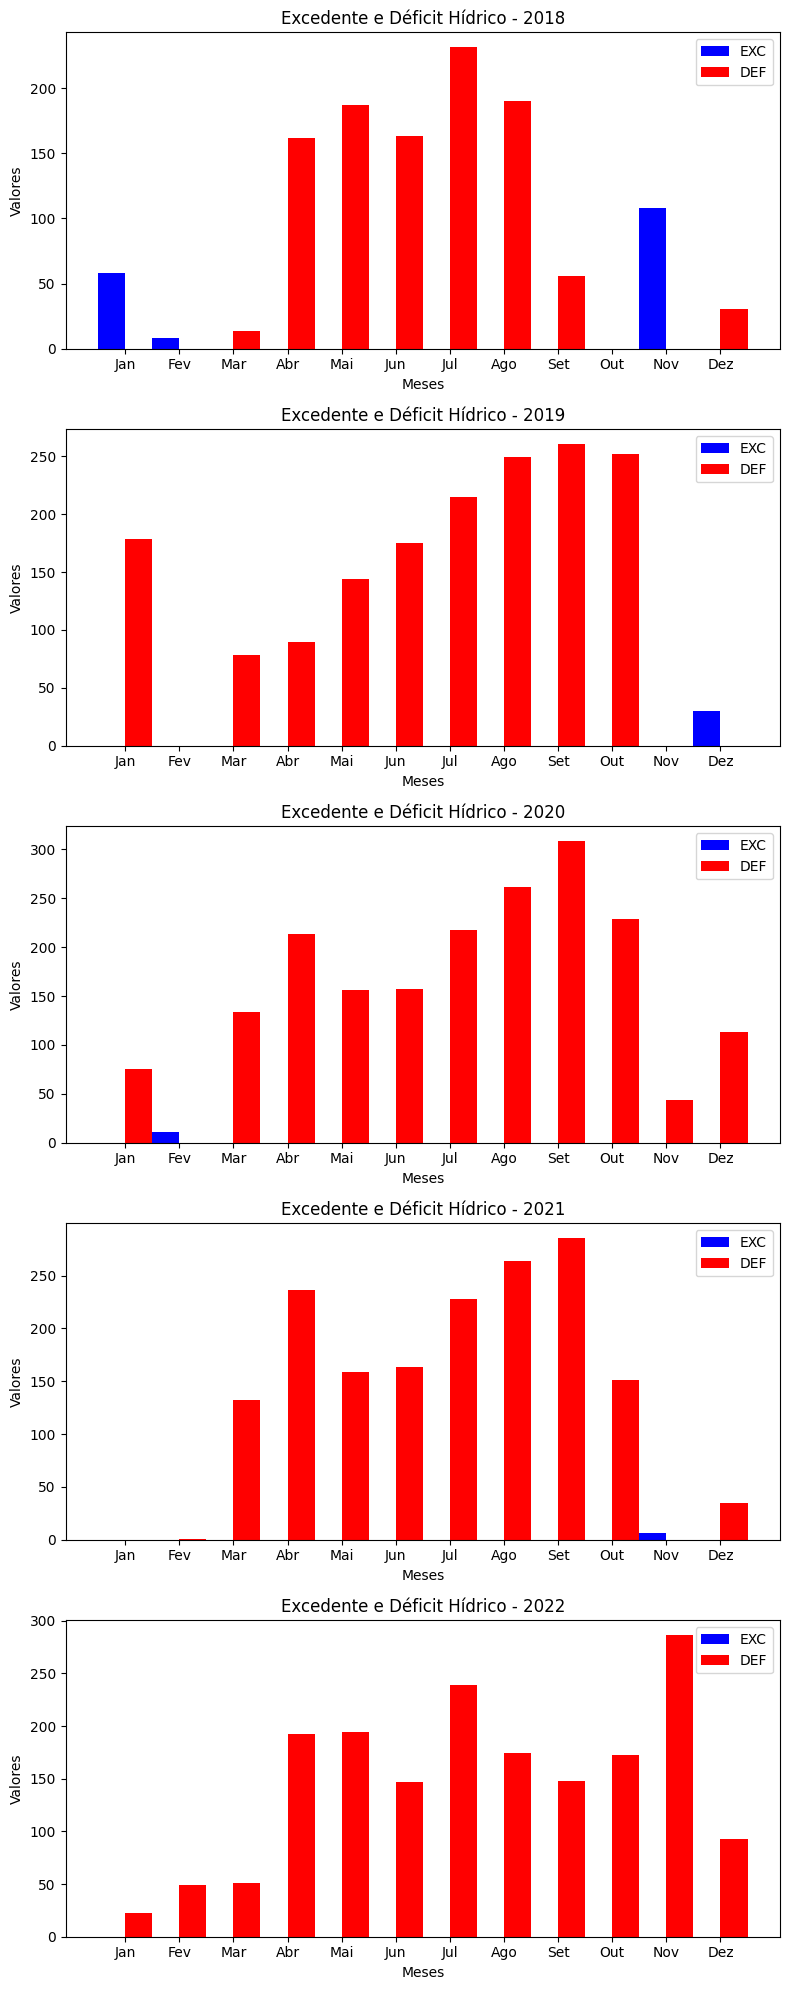

In [ ]:
# Gráficos de Excedente e Deficit Hídrico
anos = [2018,2019,2020,2021,2022]
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

# Criar subplots para cada ano
fig, axs = plt.subplots(nrows=len(anos), ncols=1, figsize=(8, 4 * len(anos)))

for i, ano in enumerate(anos):
    # Criar um gráfico de barras para cada ano
    ax = axs[i]
    bar_width = 0.5  # Largura das barras
    index = np.arange(len(meses))

    bar1 = ax.bar(index, EXC[i * 12:(i + 1) * 12], bar_width, label='EXC', color='blue')
    bar2 = ax.bar(index + bar_width,  DEF[i * 12:(i + 1) * 12], bar_width, label='DEF', color='red')

    # Adicionar rótulos
    ax.set_xlabel('Meses')
    ax.set_ylabel('Valores')
    ax.set_title(f'Excedente e Déficit Hídrico - {ano}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(meses)
    ax.legend()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir os gráficos
plt.show()


In [ ]:
'''
anos = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

# Criar subplots para cada ano
fig, axs = plt.subplots(nrows=len(anos), ncols=1, figsize=(8, 4 * len(anos)))

for i, ano in enumerate(anos):
    # Criar um gráfico de barras para cada ano
    ax = axs[i]
    bar_width = 0.35  # Largura das barras
    index = np.arange(len(meses))

    bar1 = ax.bar(index, EXC[i * 12:(i + 1) * 12], bar_width, label='EXC', color='blue')
    bar2 = ax.bar(index + bar_width, -1 * DEF[i * 12:(i + 1) * 12], bar_width, label='DEF', color='red')

    # Adicionar rótulos
    ax.set_xlabel('Meses')
    ax.set_ylabel('Valores')
    ax.set_title(f'Excedente e Déficit Hídrico - {ano}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(meses)
    ax.legend()

    # Adicionar linha de tendência
    x_line = np.arange(len(meses) + 1)  # Adicionar um ponto extra para o próximo ano
    y_line = np.polyval(np.polyfit(index + bar_width / 2, EXC[i * 12:(i + 1) * 12], 1), x_line)
    ax.plot(x_line, y_line, color='green', linestyle='dashed', linewidth=2)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir os gráficos
plt.show()
'''

In [ ]:
'''
def gerar_coeficientes_cultura(mes_semeadura, num_anos):
    # Criar um vetor base de uns
    kc_base = np.ones(12)

    # Definir o padrão de coeficientes de cultura para os 4 meses após o mês de semeadura
    padrão = np.array([0.33, 0.9, 1.1, 0.66])

    # Calcular o índice inicial com base no mês de semeadura
    indice_inicial = (mes_semeadura - 1) % 12

    # Substituir os valores no vetor base pelos valores do padrão
    kc_base[indice_inicial:indice_inicial + 4] = padrão

    # Repetir o vetor para o número de anos desejado
    kc = np.tile(kc_base, num_anos)

    return kc

# Exemplo: semeadura em fevereiro (2) e análise por 2 anos
mes_semeadura = 2
num_anos = 2

# Gerar os coeficientes de cultura
coeficientes_cultura = pd.DataFrame(gerar_coeficientes_cultura(mes_semeadura, num_anos), columns = ['Kc'])

# Imprimir o vetor resultante
print(coeficientes_cultura)
'''

In [ ]:
'''
mes_semeadura = 11
num_anos = 2
# Calcular o índice inicial com base no mês de semeadura
indice_inicial = (mes_semeadura - 1) % 12
# Criar um vetor base de uns
kc_base = np.ones(num_anos )
if indice_inicial >= 9:
  # Substituir os valores no vetor base pelos valores do padrão
  kc_base[indice_inicial:indice_inicial + (len(kc_base)-indice_inicial)] = padrao[0:len(kc_base)-indice_inicial]
  kc_base[len(padrao)-(len(kc_base)-indice_inicial)-1] = padrao[len(kc_base)-indice_inicial:]

  # Repetir o vetor para o número de anos desejado
  kc = np.tile(kc_base, num_anos)
  '''